In [184]:
import numpy as np
import pandas as pd


def remove_outliers_iqr(data: pd.Series):
    if not isinstance(data, pd.Series):
        data = pd.Series(data)

    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    non_outliers = data[(data >= lower_bound) & (data <= upper_bound)]
    mean_value = non_outliers.mean()
    data_replaced = data.apply(
        lambda x: mean_value if x < lower_bound or x > upper_bound else x
    )

    return data_replaced


def generate_well_conditioned_matrix(size):
    A = np.random.randint(-10, 10, (size, size))
    U, _, Vt = np.linalg.svd(A)
    s = np.linspace(1, 2, size)
    M = U @ np.diag(s) @ Vt
    return M @ M.T


def generate_poorly_conditioned_matrix(size):
    A = np.random.randint(-10, 10, (size, size))
    U, _, Vt = np.linalg.svd(A)
    s = np.linspace(1, 1e10, size)
    M = U @ np.diag(s) @ Vt
    return M @ M.T


def generate_symmetric_matrix(
    n: int,
    m: int,
    min_border: int = -100,
    max_border: int = 100,
) -> np.ndarray:
    if n > m:
        raise ValueError("n must be less or equal than m")

    A = np.random.uniform(min_border, max_border, size=(n, m))
    A = A @ A.T

    if n != m:
        b = np.random.uniform(min_border, max_border, size=(n, np.abs(n - m)))
        M = np.hstack((A, b.reshape(-1, 1)))

    else:
        M = A

    return M

In [185]:
def straight_iter(
    A: np.ndarray,
    x0: np.ndarray = None,
    eps: float = 1e-16,
    max_iter: int = 10**6,
) -> tuple:
    n = A.shape[0]
    x = x0.copy() if x0 is not None else np.random.rand(n)
    x = x / np.linalg.norm(x)

    iters = 0
    a = x.max()

    while iters < max_iter:
        y: np.ndarray = A @ (x / a)
        a_new = np.abs(y).max()

        iters += 1

        if np.abs(a - a_new) < eps:
            return y, a_new, iters

        x = y
        a = a_new

    return x, a, iters

In [186]:
def simple_iter(
    A: np.ndarray,
    x0: np.ndarray = None,
    eps: float = 1e-16,
    max_iter: int = 10**6,
) -> tuple:
    n = A.shape[0]
    x = x0.copy() if x0 is not None else np.random.rand(n)
    x = x / np.linalg.norm(x)

    l = 0
    for iter in range(max_iter):
        y = A @ x
        l_new = y @ x

        y_norm = y / np.linalg.norm(y)

        if np.abs(l - l_new) < eps:
            return x, l, iter

        x = y_norm
        l = l_new

    return x, l, iter

In [187]:
sizes = [i for i in range(5, 60)]
epses = [i for i in range(5, 20)]

In [188]:
from datetime import datetime

func = simple_iter

data_it_eps = {}  # эпислон - число итераций
data_t_eps = {}  # эпсилон - время
data_ac_eps = {}  # эпсилон - точность

data_it_size = {}  # размерность - число итераций
data_t_size = {}  # размерность - время
data_ac_size = {}  # размерность - точность

data_it_cond = {}  # число обусловленности - число итераций


for size in sizes:
    it_s = []
    t_s = []
    ac_s = []

    for _ in range(10):
        M = generate_symmetric_matrix(size, size)
        M /= M.max()

        start = datetime.now()
        eigvec, eigval, iters = func(M)
        end = datetime.now()

        it_s.append(iters)
        t_s.append((end - start).total_seconds() * 1000)  # ms
        ac_s.append(np.abs(np.max(np.abs(np.linalg.eigvals(M))) - eigval))

    data_it_size[size] = np.mean(it_s)
    data_t_size[size] = round(float(np.mean(t_s)), 3)
    data_ac_size[size] = np.mean(ac_s)

for eps in epses:
    it_s = []
    t_s = []
    ac_s = []

    for _ in range(10):
        M = generate_symmetric_matrix(10, 10)
        M /= M.max()

        start = datetime.now()
        eigvec, eigval, iters = func(M, eps=10 ** (-eps))
        end = datetime.now()

        it_s.append(iters)
        t_s.append((end - start).total_seconds() * 1000)  # ms
        ac_s.append(np.abs(np.max(np.abs(np.linalg.eigvals(M))) - eigval))

    data_it_eps[f"10^{eps}"] = np.mean(it_s)
    data_t_eps[f"10^{eps}"] = round(float(np.mean(t_s)), 3)
    data_ac_eps[f"10^{eps}"] = np.mean(ac_s)

In [189]:
data_it_eps = pd.DataFrame(data_it_eps.items(), columns=["eps", "iters"])
data_t_eps = pd.DataFrame(data_t_eps.items(), columns=["eps", "time"])
data_ac_eps = pd.DataFrame(data_ac_eps.items(), columns=["eps", "accuracy"])

data_it_size = pd.DataFrame(data_it_size.items(), columns=["size", "iters"])
data_t_size = pd.DataFrame(data_t_size.items(), columns=["size", "time"])
data_ac_size = pd.DataFrame(data_ac_size.items(), columns=["size", "accuracy"])

data_it_eps["iters"] = remove_outliers_iqr(data_it_eps["iters"])
data_it_size["iters"] = remove_outliers_iqr(data_it_size["iters"])

data_ac_size["accuracy"] = remove_outliers_iqr(data_ac_size["accuracy"])

<Axes: xlabel='Размерность матрицы', ylabel='Разница с numpy.eigval'>

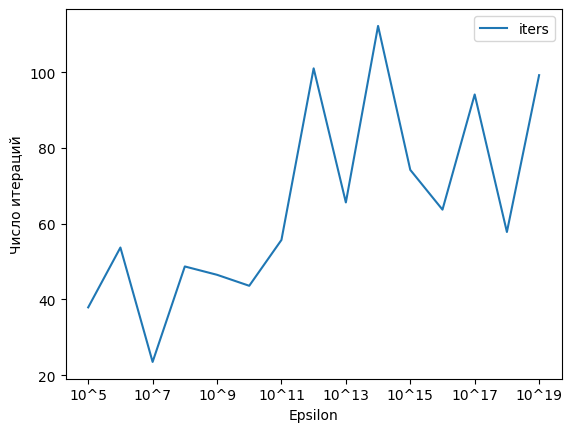

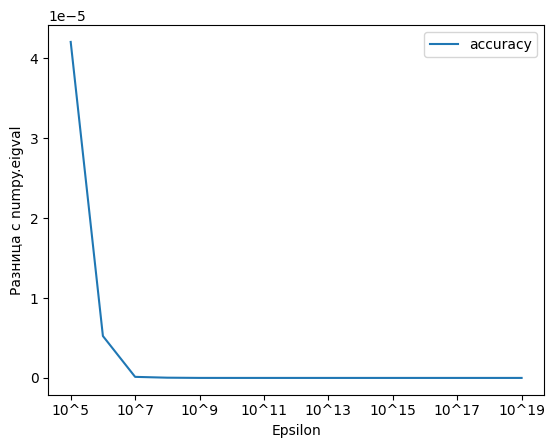

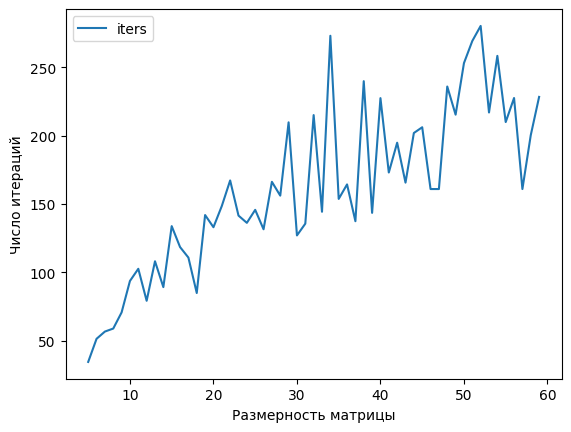

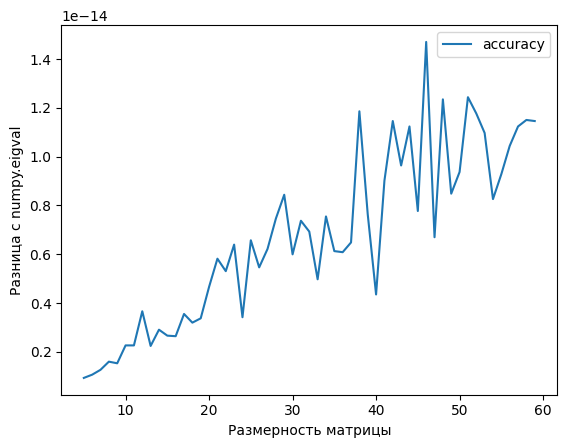

In [190]:
data_it_eps.plot(
    x="eps",
    y="iters",
    xlabel="Epsilon",
    ylabel="Число итераций",
)

# data_t_eps.plot(
#     x="eps",
#     y="time",
#     xlabel="Epsilon",
#     ylabel="Время (мс)",
# )

data_ac_eps.plot(
    x="eps",
    y="accuracy",
    xlabel="Epsilon",
    ylabel="Разница с numpy.eigval",
)

data_it_size.plot(
    x="size",
    y="iters",
    xlabel="Размерность матрицы",
    ylabel="Число итераций",
)

# data_t_size.plot(
#     x="size",
#     y="time",
#     xlabel="Размерность матрицы",
#     ylabel="Время (мс)",
# )

data_ac_size.plot(
    x="size",
    y="accuracy",
    xlabel="Размерность матрицы",
    ylabel="Разница с numpy.eigval",
)